In [1]:
%load_ext autoreload
%autoreload 2

In [53]:
import pandas as pd
import geopandas as gpd
import mscthesis
import plotly.express as px
import plotly
import plotly.graph_objects as pgo
from plotly.offline import init_notebook_mode
import numpy as np
import matplotlib.pyplot as plt

In [182]:
init_notebook_mode(connected=True)

In [245]:
import australia

In [246]:
# Which sqlite3 file to get geotweets from
sqlite_geotweets = "australia/australia.sqlite3"

# Where to save CSVs for geotweets and homelocations
csv_geotweets = '../../dbs/australia/geotweets.csv'
csv_homelocations = '../../dbs/australia/homelocations.csv'

# The boundary to use when removing users based on location.
boundary = australia.validation_boundary()

In [247]:
geotweets = mscthesis.tweets_from_sqlite(sqlite_geotweets)

# Remove "center-of-region" geotweets

When cross-posting (Instagram > Twitter) the coordinates of the geotagged tweet can be "center-of-region" coordinates and does not reflect the true position of the individual.

In [248]:
coord_counts = geotweets.groupby(['latitude', 'longitude']).size().sort_values(ascending=False)
coord_percentages = (coord_counts / geotweets.shape[0]).to_frame("perc").reset_index()

In [249]:
percentages_to_remove = coord_percentages[coord_percentages.perc > 0.001]

perc_filter = None
for (_,row) in percentages_to_remove.iterrows():
    f = (geotweets.latitude != row.latitude) & (geotweets.longitude != row.longitude)
    if perc_filter is None:
        perc_filter = f
    else:
        perc_filter = perc_filter & f

print("Removing ", perc_filter[~perc_filter].size, "center-of-region geotweets")
geotweets = geotweets[perc_filter]

Removing  195517 center-of-region geotweets


In [250]:
geotweets['createdat'] = pd.to_datetime(geotweets['createdat'], infer_datetime_format=True)

In [251]:
geotweets = geotweets.set_index(['userid', 'createdat']).sort_index()

# Filter out users few tweets

We assume that no patterns will emerge for users with less than 50 tweets, due to sparsity.


count    19747.000000
mean       287.480731
std        400.722926
min          1.000000
25%         49.000000
50%        139.000000
75%        354.500000
max       3183.000000
dtype: float64

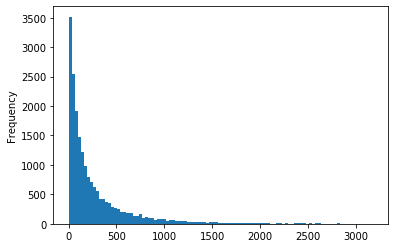

In [252]:
tweet_count_before = geotweets.groupby('userid').size()
tweet_count_before.plot.hist(bins=100)
tweet_count_before.describe()

In [253]:
geotweets = geotweets.drop(
    labels=tweet_count_before[tweet_count_before <= 50].index, 
    level=0,
)

count    14688.000000
mean       378.371460
std        428.453256
min         51.000000
25%        112.000000
50%        222.000000
75%        466.000000
max       3183.000000
dtype: float64

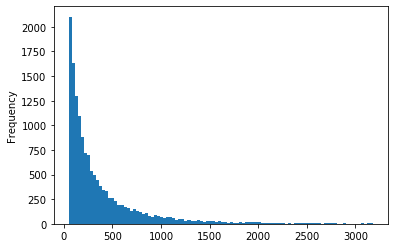

In [254]:
tweet_count = geotweets.groupby('userid').size()
tweet_count.plot.hist(bins=100)
tweet_count.describe()

In [255]:
geotweets = geotweets.reset_index('createdat')

In [256]:
geotweets = geotweets.assign(ym=geotweets['createdat'].dt.to_period('M'))

/Users/ericwennerberg/opt/miniconda3/envs/mscthesis/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1099: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [257]:
_geotweets = geotweets.loc[geotweets.index.unique()[:100]]

# Home location

In [258]:
geotweetsx = mscthesis.cluster(geotweets)
_geotweetsx = mscthesis.cluster(_geotweets)

In [259]:
geotweetsx = mscthesis.label_home(geotweetsx)
_geotweetsx = mscthesis.label_home(_geotweetsx)

## Remove tweets not in home period

Considering the long period of tweets, it is likely that users have moved between homes. To simplify our model we only keep tweets that are during detected home's "period".


In [260]:
geotweetsx = mscthesis.remove_tweets_outside_home_period(geotweetsx)
_geotweetsx = mscthesis.remove_tweets_outside_home_period(_geotweetsx)

In [261]:
user_active_period_before = geotweets.groupby('userid').apply(lambda df: df.createdat.max() - df.createdat.min())
user_active_period_after = geotweetsx.groupby('userid').apply(lambda df: df.createdat.max() - df.createdat.min())
pgo.Figure(
    [
        pgo.Histogram(x=user_active_period_before.dt.days, name="Before"),
        pgo.Histogram(x=user_active_period_after.dt.days, name="After"),
    ],
    pgo.Layout(xaxis=dict(title='Days active')),
)

In [262]:
old = geotweets.groupby('ym').size()
new = geotweetsx.groupby('ym').size()
pgo.Figure([
    pgo.Bar(x=old.index.astype(str), y=old.values, name="Before"),
    pgo.Bar(x=new.index.astype(str), y=new.values, name="After")
])

## Remove users not in region

In [263]:
def get_homelocations(ts):
    _ts = ts.query('label == "home"').groupby(['userid', 'region']).head(1)
    return gpd.GeoDataFrame(
        _ts,
        crs='EPSG:4326',
        geometry=gpd.points_from_xy(_ts['longitude'], _ts['latitude'])
    )
        
homelocations = get_homelocations(geotweetsx)
_homelocations = get_homelocations(_geotweetsx)

In [264]:
fig = px.scatter_mapbox(
    homelocations.reset_index(), 
    lat='latitude', lon='longitude', 
    hover_data = ['userid']
)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

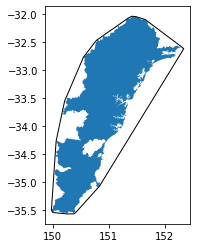

In [265]:
ax = boundary.plot()
boundary.convex_hull.plot(ax=ax, facecolor='none', edgecolor='black')

In [266]:
homelocationsx = gpd.clip(homelocations, boundary.convex_hull)
_homelocationsx = gpd.clip(_homelocations, boundary.convex_hull)

In [267]:
homelocationsx

,region,createdat,tweetid,latitude,longitude,month,weekday,hourofday,timezone,ym,label,geometry
userid,,,,,,,,,,,,
34163,1,2018-04-14 12:29:09+00:00,985132854190510080,-33.875210,151.255570,4,6,22,Australia/Sydney,2018-04,home,POINT (151.25557 -33.87521)
36303,121,2011-03-29 13:39:38+00:00,52726610197086208,-33.748644,151.045860,3,3,0,Australia/Sydney,2011-03,home,POINT (151.04586 -33.74864)
47913,97,2012-08-05 01:39:34+00:00,231927390908067840,-33.883353,151.242280,8,0,11,Australia/Sydney,2012-08,home,POINT (151.24228 -33.88335)
682193,3,2014-07-13 07:07:31+00:00,488218146063392768,-33.787272,151.283417,7,0,17,Australia/Sydney,2014-07,home,POINT (151.28342 -33.78727)
778395,48,2016-12-15 08:50:21+00:00,809319675649634304,-33.797475,151.181014,12,4,19,Australia/Sydney,2016-12,home,POINT (151.18101 -33.79748)
...,...,...,...,...,...,...,...,...,...,...,...,...
774570678615805953,2,2016-10-09 22:18:20+00:00,785243024368492544,-33.862770,151.169760,10,1,9,Australia/Sydney,2016-10,home,POINT (151.16976 -33.86277)
778143550785589249,25,2018-07-08 03:12:22+00:00,1015795700049829889,-33.883860,151.222789,7,0,13,Australia/Sydney,2018-07,home,POINT (151.22279 -33.88386)
782874951351046144,1,2016-11-07 19:09:09+00:00,795704663303749632,-33.913021,151.196551,11,2,6,Australia/Sydney,2016-11,home,POINT (151.19655 -33.91302)


In [268]:
pgo.Figure(
    [
        pgo.Scattermapbox(lat=homelocations['latitude'], lon=homelocations['longitude'], fillcolor='red'),
        pgo.Scattermapbox(lat=homelocationsx['latitude'], lon=homelocationsx['longitude'], fillcolor='blue'),
    ],
    layout=pgo.Layout(
        
        mapbox=pgo.layout.Mapbox(style='open-street-map'))
)

In [269]:
geotweetsy = geotweetsx[geotweetsx.index.isin(homelocationsx.index)]
_geotweetsy = _geotweetsx[_geotweetsx.index.isin(_homelocationsx.index)]

In [270]:
geotweetsy

,region,createdat,tweetid,latitude,longitude,month,weekday,hourofday,timezone,ym,label
userid,,,,,,,,,,,
34163,1,2018-04-14 12:29:09+00:00,985132854190510080,-33.875210,151.255570,4,6,22,Australia/Sydney,2018-04,home
34163,1,2018-04-14 12:38:33+00:00,985135215701045248,-33.875210,151.255570,4,6,22,Australia/Sydney,2018-04,home
34163,1,2018-04-21 05:09:29+00:00,987558922272804865,-33.875210,151.255570,4,6,15,Australia/Sydney,2018-04,home
34163,1,2018-06-12 09:01:47+00:00,1006461551790972928,-33.875210,151.255570,6,2,19,Australia/Sydney,2018-06,home
34163,1,2018-06-15 23:57:58+00:00,1007774246355943424,-33.875210,151.255570,6,6,9,Australia/Sydney,2018-06,home
...,...,...,...,...,...,...,...,...,...,...,...
790766431428194304,22,2018-06-28 08:03:59+00:00,1012245210343067648,-33.887037,151.240355,6,4,18,Australia/Sydney,2018-06,other
790766431428194304,23,2018-10-31 08:16:45+00:00,1057546906665172992,-33.872999,151.209823,10,3,19,Australia/Sydney,2018-10,other
790766431428194304,24,2018-12-10 09:04:36+00:00,1072054462787805185,-34.013426,150.818386,12,1,20,Australia/Sydney,2018-12,other


In [271]:
geotweetsy.to_csv(csv_geotweets)

In [272]:
homelocationsx[['latitude', 'longitude']].to_csv(csv_homelocations)